In [61]:
# -*- coding: utf-8 -*-
import multiprocessing
import pickle
import time
time.clock= time.time
import sys

from scipy.special import polygamma as pg
from scipy.special import psi as psi

import numpy as np

SMALL_NUMBER = 1e-100

# This is the LDA implementation to use
# K = number of topics
# eta = hyperparameter for topics (i.e. pseudo word counts)
# alpha = initial Dirichlet hyperparameter
# update_alpha = boolean to determine whether or not alpha is updated at each iteration
# word_index is a dictionary storing the position of each feature in numpy arrays
 # word_index is only used in multi-file as it's important that features are always in the same order.
 # In single file it is created internally
class VariationalLDA(object):
    def __init__(self,corpus=None,K = 20,eta=0.1,
        alpha=1,update_alpha=True,word_index=None,normalise = -1,fixed_topics = None,fixed_topics_metadata = None,
        topic_index = None,top_verbose = True):
        self.corpus = corpus
        self.word_index = word_index
        self.normalise = normalise
        #  If the corpus exists, make the word index and the (unused?) word doc matrix
        if not self.corpus == None:
            self.n_docs = len(self.corpus)
            if self.word_index == None:
                self.word_index = self.find_unique_words()
            if top_verbose:
                print ("Object created with {} documents".format(self.n_docs))
            self.n_words = len(self.word_index)
            self.make_doc_index()
            if self.normalise > -1:
                if top_verbose:
                    print ("Normalising intensities")
                #self.normalise_intensities()
        
        self.K = K

        if fixed_topics:
            self.n_fixed_topics = len(fixed_topics)
            self.K += self.n_fixed_topics
        else:
            self.n_fixed_topics = 0


        self.alpha = alpha
        #  If alpha is a single value, make it into a vector
        if type(self.alpha) == int or type(self.alpha) == float:
            self.alpha = self.alpha*np.ones(self.K)
        self.eta = eta # Smoothing parameter for beta
        self.update_alpha = update_alpha
        self.doc_metadata = None
        

        # self.topic_index = topic_index
        # self.topic_metadata = topic_metadata
        self.topic_index = topic_index
        if not self.topic_index:
            self.topic_index = {}
            self.topic_metadata = {}
            topic_pos = 0
            if fixed_topics:
                for topic_name in fixed_topics:
                    self.topic_index[topic_name] = topic_pos
                    #self.topic_metadata[topic_name] = fixed_topics_metadata[topic_name]
                    #self.topic_metadata[topic_name]['type'] = 'fixed'
                    topic_pos += 1
        
            for topic_pos in range(self.n_fixed_topics,self.K):
                topic_name = 'motif_{}'.format(topic_pos)
                #self.topic_index[topic_name] = topic_pos
                #self.topic_metadata[topic_name] = {'name':topic_name,'type':'learnt'}

        if fixed_topics:
            self._add_exact_fixed_topics(fixed_topics)
            

    def _add_exact_fixed_topics(self,fixed_topics):
        # first add any missing words
        #word_pos = max(self.word_index.values())+1

        #for topic,spectrum in fixed_topics.items():
         #   for word in spectrum:
          #      if not word in self.word_index:
           #         self.word_index[word] = word_pos
            #        word_pos += 1
        #self.n_words = len(self.word_index)

        # Now make the fixed rows of beta
        self.beta_matrix = np.zeros((self.K,self.n_words),np.float64) + SMALL_NUMBER
        #self.beta_matrix[0:50,:] = fixed_topics
        for topic_pos,spectrum in fixed_topics.items():
                for word_pos,val in spectrum.items():
                    self.beta_matrix[topic_pos,word_pos] = val
                self.beta_matrix[topic_pos,:] /= self.beta_matrix[topic_pos,:].sum()


    def create_word_index (self,df):
        word_index = {}
        pos = 0
        for word in list(df.T.columns):
            word_index[word] = pos
            pos += 1
        return word_index
   
    def create_doc_index (self,df):
        self.doc_index = {}
        doc_pos = 0
        for doc in list(df.T.index):
            self.doc_index[doc] = doc_pos
            doc_pos += 1
                
    def load_data_sc(self,df):
        print ("Edited")
        self.n_docs = df.T.shape[0]
        self.word_index = self.create_word_index(df)
        self.create_doc_index(df)
        self.n_words = df.T.shape[1]
        self.corpus = df.T.to_dict(orient="index")
        for doc in self.corpus.keys(): 
            self.corpus[doc] = {key:val for key, val in self.corpus[doc].items() if val != 0}
        
 
        
        
   
    # Run the VB inference. Verbose = True means it gives output each iteration
    # initialise = True initialises (i.e. restarts the algorithm)
    # This means we can run the algorithm from where it got to.
    # First time its run, initialise has to be True
    def run_vb(self,n_its = 1,verbose=True,initialise=True):
        if initialise:
            if verbose:
                print ("Initialising")
            self.init_vb()
        if verbose:
            print ("Starting iterations")
        for it in range(n_its):
            start_time = time.clock()
            diff = self.vb_step()
            end_time = time.clock()
            self.its_performed += 1
            estimated_finish = ((end_time - start_time)*(n_its - it)/60.0)
            if verbose:
                print ("Iteration {} (change = {}) ({} seconds, I think I'll finish in {} minutes). Alpha: ({},{})".format(it,diff,end_time - start_time,estimated_finish,self.alpha.min(),self.alpha.max()))

    # D a VB step
    def vb_step(self):
        # Run an e-step
        temp_beta = self.e_step()
        temp_beta += self.eta
        # Do the normalisation in the m step
        if self.n_fixed_topics > 0:
            temp_beta[:self.n_fixed_topics,:] = self.beta_matrix[:self.n_fixed_topics,:]
        temp_beta /= temp_beta.sum(axis=1)[:,None]
        # Compute how much the word probabilities have changed
        total_difference = (np.abs(temp_beta - self.beta_matrix)).sum()
        self.beta_matrix = temp_beta
        # If we're updating alpha, run the alpha update
        if self.update_alpha:
            self.alpha = self.alpha_nr(init_alpha = self.alpha.copy())
        return total_difference
        # self.m_step()

    # Newton-Raphson procedure for updating alpha
    def alpha_nr(self,maxit=20,init_alpha=[]):
        old_alpha = self.alpha.copy()
        try:
            M,K = self.gamma_matrix.shape
            if not len(init_alpha) > 0:
                init_alpha = self.gamma_matrix.mean(axis=0)/K
            alpha = init_alpha.copy()
            alphap = init_alpha.copy()
            g_term = (psi(self.gamma_matrix) - psi(self.gamma_matrix.sum(axis=1))[:,None]).sum(axis=0)
            for it in range(maxit):
                grad = M *(psi(alpha.sum()) - psi(alpha)) + g_term
                H = -M*np.diag(pg(1,alpha)) + M*pg(1,alpha.sum())


                # playing here....
                z = M*pg(1,alpha.sum())
                h = -M*pg(1,alpha)
                c = ((grad/h).sum())/((1.0/z) + (1.0/h).sum())
                alpha_change = (grad - c)/h

                n_bad = (alpha_change > alpha).sum()
                while n_bad > 0:
                    alpha_change/=2.0
                    n_bad = (alpha_change > alpha).sum()

                
                alpha_new = alpha - alpha_change

                pos = np.where(alpha_new <= SMALL_NUMBER)[0]
                alpha_new[pos] = SMALL_NUMBER

                # if (alpha_new < 0).sum() > 0:
                #   init_alpha /= 10.0
                #   return self.alpha_nr(maxit=maxit,init_alpha = init_alpha)

                diff = np.sum(np.abs(alpha-alpha_new))
                alpha = alpha_new
                if diff < 1e-6 and it > 1:
                    return alpha
        except:
            alpha = old_alpha
        return alpha

    # TODO: tidy up and comment this function
    def e_step(self):
        temp_beta = np.zeros((self.K,self.n_words))
        for doc in self.corpus:
            d = self.doc_index[doc]
            temp_gamma = np.zeros(self.K) + self.alpha
            for word in self.corpus[doc]:
                w = self.word_index[word]
                log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T
                # self.phi_matrix[doc][word] = self.beta_matrix[:,w]*np.exp(psi(self.gamma_matrix[d,:])).T
                # for k in range(self.K):
                #   self.phi_matrix[doc][word][k] = self.beta_matrix[k,w]*np.exp(scipy.special.psi(self.gamma_matrix[d,k]))
                log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
                self.phi_matrix[doc][word] = log_phi_matrix/log_phi_matrix.sum()
                # self.phi_matrix[doc][word] /= self.phi_matrix[doc][word].sum()
                temp_gamma += self.phi_matrix[doc][word]*self.corpus[doc][word]
                temp_beta[:,w] += self.phi_matrix[doc][word] * self.corpus[doc][word]
            # self.phi_matrix[d,:,:] = (self.beta_matrix * self.word_matrix[d,:][None,:] * (np.exp(scipy.special.psi(self.gamma_matrix[d,:]))[:,None])).T
            # self.phi_matrix[d,:,:] /= self.phi_matrix[d,:,:].sum(axis=1)[:,None]
            # self.gamma_matrix[d,:] = self.alpha + self.phi_matrix[d,:,:].sum(axis=0)
            self.gamma_matrix[d,:] = temp_gamma
            pos = np.where(self.gamma_matrix[d,:]<SMALL_NUMBER)[0]
            self.gamma_matrix[d,pos] = SMALL_NUMBER
        return temp_beta

    # Function to find the unique words in the corpus and assign them to indices
    def find_unique_words(self):
        word_index = {}
        pos = 0
        for doc in self.corpus:
            for word in self.corpus[doc]:
                if not word in word_index:
                    word_index[word] = pos
                    pos += 1
        print ("Found {} unique words".format(len(word_index)))
        return word_index

    # Pretty sure this matrix is never used
    def make_doc_index(self):
        self.doc_index = {}
        doc_pos = 0
        for doc in self.corpus:
            self.doc_index[doc] = doc_pos
            doc_pos += 1

    # Initialise the VB algorithm
    # TODO: tidy this up
    def init_vb(self):
        # self.gamma_matrix = np.zeros((self.n_docs,self.K),np.float) + 1.0
        # self.phi_matrix = np.zeros((self.n_docs,self.n_words,self.K))
        self.its_performed = 0
        self.phi_matrix = {}
        self.gamma_matrix = np.zeros((self.n_docs,self.K))
        for doc in self.corpus:
            self.phi_matrix[doc] = {}
            for word in self.corpus[doc]:
                self.phi_matrix[doc][word] = np.zeros(self.K)
            d = self.doc_index[doc]
            doc_total = 0.0
            for word in self.corpus[doc]:
                doc_total += self.corpus[doc][word]
            self.gamma_matrix[d,:] = self.alpha + 1.0*doc_total/self.K
        # # Normalise this to sum to 1
        # self.phi_matrix /= self.phi_matrix.sum(axis=2)[:,:,None]

        # Initialise the betas
        if self.n_fixed_topics == 0:
            # self.beta_matrix = np.random.rand(self.K,self.n_words)
            self.beta_matrix = np.zeros((self.K,self.n_words),np.double)
            for k in range(self.K):
                self.beta_matrix[k,:] = np.random.dirichlet(self.eta*np.ones(self.n_words)) 
        else:
            print ("Here")
            for k in range(self.n_fixed_topics,self.K):
                self.beta_matrix[k,:] = np.random.dirichlet(self.eta*np.ones(self.n_words))
        self.beta_matrix /= self.beta_matrix.sum(axis=1)[:,None]

    # Function to return a dictionary with keys equal to documents and values equal to the probability
    # of the requested document (used for visusaling in DESI imaging)
    def get_topic_as_doc_dict(self,topic_id,thresh = 0.001,normalise=False):
        top = {}
        mat = self.gamma_matrix
        if normalise:
            mat = self.get_expect_theta()

        for doc in self.doc_index:
            pos = self.doc_index[doc]
            if mat[pos,topic_id] >= thresh:
                top[doc] = mat[pos,topic_id]
        return top

    # Return a topic as a dictionary over words
    def get_topic_as_dict(self,topic_id):
        top = {}
        for word in self.word_index:
            top[word] = self.beta_matrix[topic_id,self.word_index[word]]
        return top

    # Return the topic probabilities for all documents 
    # Note that self.doc_index maps the document names to their
    # position in this matrix
    def get_expect_theta(self):
        e_theta = self.gamma_matrix.copy()
        e_theta /= e_theta.sum(axis=1)[:,None]
        return e_theta

    def get_beta(self):
        return self.beta_matrix.copy()

    def make_dictionary(self,metadata=None,min_prob_to_keep_beta = 1e-3,
        min_prob_to_keep_phi = 1e-2,min_prob_to_keep_theta = 1e-2,
        filename = None,features = None,compute_overlaps = True):

        if metadata == None:
            if self.doc_metadata == None:
                metadata = {}
                for doc in self.corpus:
                    metadata[doc] = {'name': doc,'parentmass': float(doc.split('_')[0])}
            else:
                metadata = self.doc_metadata

        lda_dict = {}
        lda_dict['corpus'] = self.corpus
        lda_dict['word_index'] = self.word_index
        lda_dict['doc_index'] = self.doc_index
        lda_dict['K'] = self.K
        lda_dict['alpha'] = list(self.alpha)
        lda_dict['beta'] = {}
        lda_dict['doc_metadata'] = metadata
        lda_dict['topic_index'] = self.topic_index
        lda_dict['topic_metadata'] = self.topic_metadata
        
        pure_gamma = []
        for gamma in self.gamma_matrix:
            pure_gamma.append(list(gamma))

        lda_dict['gamma'] = gamma

        if features:
            lda_dict['features'] = features

        # Create the inverse indexes
        wi = []
        for i in self.word_index:
            wi.append((i,self.word_index[i]))
        wi = sorted(wi,key = lambda x: x[1])

        di = []
        for i in self.doc_index:
            di.append((i,self.doc_index[i]))
        di = sorted(di,key=lambda x: x[1])

        ri,i = zip(*wi)
        ri = list(ri)
        di,i = zip(*di)
        di = list(di)

        # make a reverse index for topics
        tp = [(topic,self.topic_index[topic]) for topic in self.topic_index]
        tp = sorted(tp,key = lambda x: x[1])
        reverse,_ = zip(*tp)

        for k in range(self.K):
            pos = np.where(self.beta_matrix[k,:]>min_prob_to_keep_beta)[0]
            motif_name = reverse[k]
            # motif_name = 'motif_{}'.format(k)
            lda_dict['beta'][motif_name] = {}
            for p in pos:
                word_name = ri[p]
                lda_dict['beta'][motif_name][word_name] = self.beta_matrix[k,p]

        eth = self.get_expect_theta()
        lda_dict['theta'] = {}
        for i,t in enumerate(eth):
            doc = di[i]
            lda_dict['theta'][doc] = {}
            pos = np.where(t > min_prob_to_keep_theta)[0]
            for p in pos:
                motif_name = reverse[p]
                # motif_name = 'motif_{}'.format(p)
                lda_dict['theta'][doc][motif_name] = t[p]

        lda_dict['phi'] = {}
        ndocs = 0
        for doc in self.corpus:
            ndocs += 1
            lda_dict['phi'][doc] = {}
            for word in self.corpus[doc]:
                lda_dict['phi'][doc][word] = {}
                pos = np.where(self.phi_matrix[doc][word] >= min_prob_to_keep_phi)[0]
                for p in pos:
                    motif_name = reverse[p]
                    lda_dict['phi'][doc][word][motif_name] = self.phi_matrix[doc][word][p]
            if ndocs % 500 == 0:
                print ("Done {}".format(ndocs))

        if compute_overlaps:
            os = compute_overlap_scores(lda_dict)
            lda_dict['overlap_scores'] = os

        if not filename == None:
            with open(filename,'w') as f:
                pickle.dump(lda_dict,f)

        return lda_dict



In [62]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.patches as mpatches

from scipy import spatial
from scipy.stats import binom
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.spatial.distance import cosine
from itertools import combinations

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)


#returns a re-normalised delta: all new topics set to 0; old ones normalised
def deltaCell(cellID,documentTopicMatrix,oldTopics,allTopics):
    theta = documentTopicMatrix.loc[cellID]
    delta = np.zeros(allTopics)
    totalSum = sum(theta[0:oldTopics])
    delta[0:oldTopics] = theta[0:oldTopics]/totalSum
    return delta 


def calculateProbs(cellID, geneName,totalTopics,oldTopics,doubletsMatrix,topicWordsMatrix,documentTopicMatrix):
    total = 0
    total2 = 0
    n = doubletsMatrix.T[cellID].sum()
    x = doubletsMatrix.T[cellID][geneName]
    delta = deltaCell(cellID,documentTopicMatrix,oldTopics, totalTopics)
    p = topicWordsMatrix[geneName][0:totalTopics].values
    prob = (1-binom.cdf(x, n, p))+binom.pmf(x, n, p)
    total = sum(documentTopicMatrix.T[cellID].values*prob)
    total2 = sum(delta*prob)
    return (total, total2)


def expectedActualPlot(geneName,totalTopics,oldTopics,cellMatrix,topicWordsMatrix,documentTopicMatrix,dpi=120):
    x = []
    y = []
    for i in cellMatrix.index:
        t,t1= calculateProbs(i,geneName,totalTopics,oldTopics,cellMatrix,topicWordsMatrix,documentTopicMatrix)
        x.append(t)
        y.append(t1)
    plt.scatter(x,y)
    plt.title(geneName,fontsize=20)
    plt.xlabel("Probability given all topics",fontsize=15)
    plt.ylabel("Probability given initial topics",fontsize=15)
    plt.tight_layout()
    plt.savefig(geneName+"_prob_plot.png",dpi=dpi)
    
    

def lrtest(llmin, llmax):
    lr = -2 * (np.log(llmin)-np.log(llmax))
    p = stats.chisqprob(lr,30)
    return lr, p


#gene ranking per topic
def ranking_genes (oldTopicNum, newTopicsNum,scLDAObject,geneNames):
    interesting_genes = pd.DataFrame()
    for k in range(oldTopicNum,newTopicsNum):
        genesNeed = []
        in_newT = []
        percentages = []
        for geneName in geneNames:
            in_new = 0
            in_old = 0
            for key in scLDAObject.phi_matrix.keys():
                if geneName in scLDAObject.phi_matrix[key].keys():
                    if scLDAObject.phi_matrix[key][geneName].argmax()==k:
                        in_new+=1
                    else:
                        in_old+=1
            if in_new>0:
                genesNeed.append(geneName)
                in_newT.append(in_new)
                percentages.append(in_new/(in_new+in_old))
        ranked_genes = pd.DataFrame([genesNeed,in_newT,percentages,np.full((len(genesNeed),1),k)])
        ranked_genes = ranked_genes.T
        ranked_genes = ranked_genes.sort_values([2,1],ascending=False)
        interesting_genes = pd.concat([interesting_genes,ranked_genes])
    
    return interesting_genes


def ranking_genes_realData (oldTopicNum, newTopicsNum,scLDAObject,geneNames):
    interesting_genes = pd.DataFrame()
    for k in range(oldTopicNum,newTopicsNum):
        genesNeed = []
        in_newT = []
        percentages = []
        for geneName in geneNames:
            in_new = 0
            in_old = 0
            for key in scLDAObject.phi_matrix.keys():
                if geneName in scLDAObject.phi_matrix[key].keys():
                    if scLDAObject.phi_matrix[key][geneName].argmax()==k:
                        in_new+=1
                    else:
                        in_old+=1
            if in_new>0:
                genesNeed.append(geneName)
                in_newT.append(in_new)
                percentages.append(in_new/(in_new+in_old))
        ranked_genes = pd.DataFrame([genesNeed,in_newT,percentages,np.full((len(genesNeed),1),k)])
        ranked_genes = ranked_genes.T
        ranked_genes = ranked_genes.sort_values([2,1],ascending=False)
        interesting_genes = interesting_genes.append(ranked_genes[ranked_genes[1]>10])
        
    return interesting_genes



def getROCarrays(oldT,newT,interesting_genes,ground_truth,cutOffList):
    p = []
    n = []
    for i in cutOffList:
        pos,neg = rocCurveValues(oldT,newT,interesting_genes, ground_truth,i)
        p.append(len(pos))
        n.append(len(list(set(neg))))
    return p,n
    
    
def rocCurveValues(oldT, newT,interesting_genes,ground_truth,topGenesCutOff):
    positive = []
    negative = []
    for i in range(oldT,newT):
        for k in interesting_genes[interesting_genes[3]==i].sort_values([1],ascending=False)[0:topGenesCutOff][0].values:
            if k in ground_truth and k not in positive: 
                positive.append(k)
            if k not in ground_truth:
                negative.append(k)
    return positive, negative



def computeCosine (LDAModel,topic1, topic2):
    t1 = LDAModel.beta_matrix[topic1]
    t2 = LDAModel.beta_matrix[topic2]
    return 1-cosine(t1,t2)


def averageDistance(LDAModel):
    totalDistance = 0
    nT = LDAModel.beta_matrix.shape[0]
    numTopics = [i for i in range(0,nT)]
    combs = combinations(numTopics,2)
    for i in list(combs):
        totalDistance+=computeCosine(LDAModel,i[0],i[1])
    
    totalDistance = totalDistance/(nT*(nT-1)/2)
    return totalDistance

    
    


    

In [63]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sb
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib.transforms import Bbox
#sys.path.append('../code/')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
#from ldaSingleCell import VariationalLDA
#from utilsFuncs import *
import re



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
my_obj = pd.read_csv('PD.csv', header=0, index_col=0)

In [18]:
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation

# Read the dataset from 'PD.csv'
dataset = pd.read_csv('PD.csv', header=0, index_col=0)
print("Done reading file")

numTopics = np.arange(2,20)
valsPerplexity = []

for k in numTopics:
    lda = LatentDirichletAllocation(n_components=k, doc_topic_prior=1, topic_word_prior=0.005)
    output = lda.fit_transform(dataset.T)
    perp = lda.perplexity(dataset.T)
    valsPerplexity.append(int(perp))

print("Writing results")
result = pd.DataFrame({'topics': numTopics, 'perplexity': valsPerplexity})
result.to_csv("perplexities.csv", index=False)


Done reading file
Writing results


Text(0, 0.5, 'perplexity')

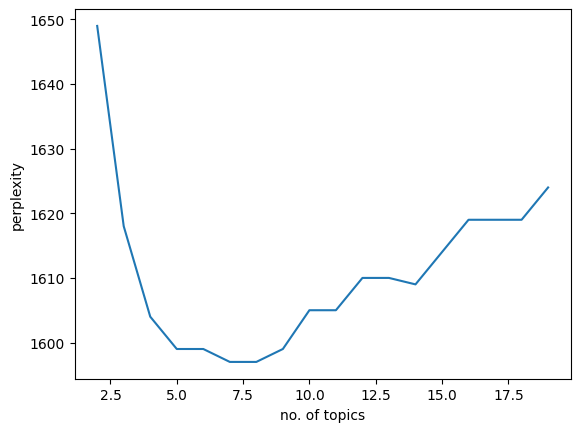

In [32]:
perplex= pd.read_csv('perplexities.csv', header=0)
y= perplex['perplexity']
x=perplex['topics']
plt.plot(x, y)
plt.xlabel('no. of topics')
plt.ylabel('perplexity')

In [38]:
Meta= pd.read_csv('PD_meta.csv', header=0, index_col=0)

In [41]:
my_obj.shape

(23153, 2468)

In [42]:
Meta.shape

(2468, 24)

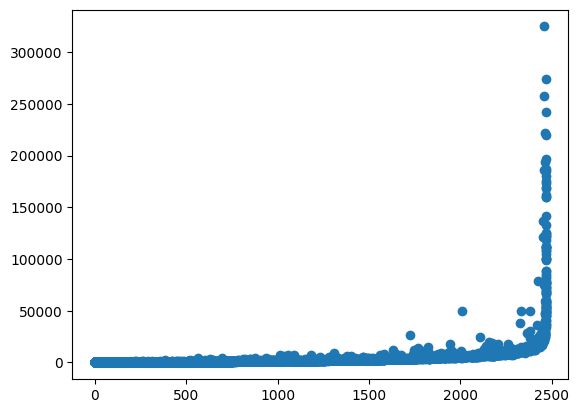

In [43]:
CountsAll= my_obj
plt.plot(CountsAll.astype(bool).sum(axis=1),CountsAll.sum(axis=1),'o')

In [44]:
countsAll= CountsAll
countsAll[(countsAll.astype(bool).sum(axis=1)>100) & (countsAll.astype(bool).sum(axis=1)<10000)]

,AAACCTGAGAATAGGG_SOL004,AAACCTGCAAGCTGTT_SOL004,AAACCTGCAATGAATG_SOL004,AAACCTGCAGCTGCTG_SOL004,AAACCTGCATGGGAAC_SOL004,AAACCTGGTAAGTTCC_SOL004,AAACCTGGTTCAGTAC_SOL004,AAACCTGTCATTATCC_SOL004,AAACGGGAGATGCCAG_SOL004,AAACGGGCACTGTCGG_SOL004,...,TTTGCGCTCGAACGGA_SOL004,TTTGGTTAGTTAGGTA_SOL004,TTTGGTTGTTCGAATC_SOL004,TTTGGTTTCAGGTTCA_SOL004,TTTGGTTTCCTCAACC_SOL004,TTTGTCACAATCTGCA_SOL004,TTTGTCACAGTACACT_SOL004,TTTGTCAGTTCGCGAC_SOL004,TTTGTCATCACGAAGG_SOL004,TTTGTCATCCAACCAA_SOL004
FO538757.2,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,2,2,0,0,0
AP006222.2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
RP11-206L10.9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
RP11-54O7.1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC011043.1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
AC007325.4,0,0,0,0,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
AL354822.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
AC004556.1,0,1,1,1,1,0,0,2,0,0,...,0,0,2,0,0,1,0,1,0,0


In [45]:
countsFiltered = countsAll[(countsAll.astype(bool).sum(axis=1)>100) & (countsAll.astype(bool).sum(axis=1)<10000)]


In [46]:
countsFiltered

,AAACCTGAGAATAGGG_SOL004,AAACCTGCAAGCTGTT_SOL004,AAACCTGCAATGAATG_SOL004,AAACCTGCAGCTGCTG_SOL004,AAACCTGCATGGGAAC_SOL004,AAACCTGGTAAGTTCC_SOL004,AAACCTGGTTCAGTAC_SOL004,AAACCTGTCATTATCC_SOL004,AAACGGGAGATGCCAG_SOL004,AAACGGGCACTGTCGG_SOL004,...,TTTGCGCTCGAACGGA_SOL004,TTTGGTTAGTTAGGTA_SOL004,TTTGGTTGTTCGAATC_SOL004,TTTGGTTTCAGGTTCA_SOL004,TTTGGTTTCCTCAACC_SOL004,TTTGTCACAATCTGCA_SOL004,TTTGTCACAGTACACT_SOL004,TTTGTCAGTTCGCGAC_SOL004,TTTGTCATCACGAAGG_SOL004,TTTGTCATCCAACCAA_SOL004
FO538757.2,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,2,2,0,0,0
AP006222.2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
RP11-206L10.9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
RP11-54O7.1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC011043.1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
AC007325.4,0,0,0,0,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
AL354822.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
AC004556.1,0,1,1,1,1,0,0,2,0,0,...,0,0,2,0,0,1,0,1,0,0


In [47]:
p = re.compile("RPS|RPL|RP")
list(filter(p.match,countsFiltered.index.values))

['RP11-206L10.9',
 'RP11-54O7.1',
 'RP11-345P4.9',
 'RPL22',
 'RP11-108M9.4',
 'RPL11',
 'RP4-594I10.3',
 'RPA2',
 'RP1-39G22.7',
 'RPS8',
 'RPF1',
 'RP4-665J23.1',
 'RPAP2',
 'RPL5',
 'RP11-421L21.3',
 'RP5-1065J22.8',
 'RP11-14N7.2',
 'RP11-337C18.8',
 'RPRD2',
 'RP11-126K1.6',
 'RP11-422P24.12',
 'RPS27',
 'RP11-307C12.12',
 'RP1-79C4.4',
 'RP11-307B6.3',
 'RP11-61J19.5',
 'RPS6KC1',
 'RP11-392O17.1',
 'RP11-95P13.1',
 'RP11-452F19.3',
 'RP11-295G20.2',
 'RP5-862P8.2',
 'RP5-827C21.4',
 'RP11-488L18.10',
 'RPS7',
 'RP11-95D17.1',
 'RP11-254F7.2',
 'RP11-490M8.1',
 'RPS27A',
 'RP11-554J4.1',
 'RPIA',
 'RPL31',
 'RP11-332H14.2',
 'RP11-803D5.4',
 'RP11-65I12.1',
 'RP11-141B14.1',
 'RP11-395A13.2',
 'RP11-725P16.2',
 'RP11-796E10.1',
 'RPE',
 'RPL37A',
 'RPUSD3',
 'RPL32',
 'RPL15',
 'RPSA',
 'RPL14',
 'RP11-708J19.1',
 'RPL29',
 'RPP14',
 'RPL24',
 'RP11-553L6.5',
 'RP11-18H7.1',
 'RPN1',
 'RPL22L1',
 'RPL39L',
 'RPL35A',
 'RP11-440L14.1',
 'RPL9',
 'RP11-109G23.3',
 'RP11-499E18.1',


In [48]:
countsFiltered = countsFiltered.drop(list(filter(p.match,countsFiltered.index.values)),axis=0)

In [49]:
countsFiltered

,AAACCTGAGAATAGGG_SOL004,AAACCTGCAAGCTGTT_SOL004,AAACCTGCAATGAATG_SOL004,AAACCTGCAGCTGCTG_SOL004,AAACCTGCATGGGAAC_SOL004,AAACCTGGTAAGTTCC_SOL004,AAACCTGGTTCAGTAC_SOL004,AAACCTGTCATTATCC_SOL004,AAACGGGAGATGCCAG_SOL004,AAACGGGCACTGTCGG_SOL004,...,TTTGCGCTCGAACGGA_SOL004,TTTGGTTAGTTAGGTA_SOL004,TTTGGTTGTTCGAATC_SOL004,TTTGGTTTCAGGTTCA_SOL004,TTTGGTTTCCTCAACC_SOL004,TTTGTCACAATCTGCA_SOL004,TTTGTCACAGTACACT_SOL004,TTTGTCAGTTCGCGAC_SOL004,TTTGTCATCACGAAGG_SOL004,TTTGTCATCCAACCAA_SOL004
FO538757.2,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,2,2,0,0,0
AP006222.2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
NOC2L,0,0,1,0,0,1,0,0,0,1,...,0,0,1,0,0,3,1,0,1,0
HES4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC011043.1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
AC007325.4,0,0,0,0,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
AL354822.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
AC004556.1,0,1,1,1,1,0,0,2,0,0,...,0,0,2,0,0,1,0,1,0,0


In [50]:
referenceCells= Meta[Meta['neigb_class']=='Singlet']

In [51]:
Meta.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_label', 'sample_name',
       'patient_id', 'sample_type', 'sample_site', 'label_short', 'percent.mt',
       'tissue', 'RNA_snn_res.0.35', 'seurat_clusters', 'celltype_hpca',
       'celltype_main', 'celltype_fine', 'ScType_cell', 'refined_celltype',
       'new.clusters', 'final_clusters', 'survival', 'stage', 'neigb_class',
       'neigb_type'],
      dtype='object')

In [52]:
referenceCells.head

<bound method NDFrame.head of                         orig.ident  nCount_RNA  nFeature_RNA   
AAACCTGAGAATAGGG_SOL004         OV       10602          3208  \
AAACCTGCAAGCTGTT_SOL004         OV        7594          2484   
AAACCTGCAATGAATG_SOL004         OV        5232          2027   
AAACCTGCAGCTGCTG_SOL004         OV       13181          3098   
AAACCTGCATGGGAAC_SOL004         OV        6816          2557   
...                            ...         ...           ...   
TTTGGTTTCCTCAACC_SOL004         OV        7059          2667   
TTTGTCACAATCTGCA_SOL004         OV       10500          3800   
TTTGTCAGTTCGCGAC_SOL004         OV       10551          3106   
TTTGTCATCACGAAGG_SOL004         OV        7337          2581   
TTTGTCATCCAACCAA_SOL004         OV        8880          2507   

                                      cell_label sample_name patient_id   
AAACCTGAGAATAGGG_SOL004  AAACCTGAGAATAGGG_SOL004      SOL004         P3  \
AAACCTGCAAGCTGTT_SOL004  AAACCTGCAAGCTGTT_SOL004   

In [53]:
#referenceCells.index = [i.replace("-",".") for i in referenceCells.index]

In [54]:
countsFiltered.T

,FO538757.2,AP006222.2,SAMD11,NOC2L,HES4,ISG15,AGRN,SDF4,B3GALT6,UBE2J2,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC011043.1,AC007325.4,AL354822.1,AC004556.1,AC240274.1
AAACCTGAGAATAGGG_SOL004,0,0,0,0,0,0,0,5,0,0,...,2,228,11,2,148,0,0,0,0,0
AAACCTGCAAGCTGTT_SOL004,1,1,0,0,0,0,0,1,0,1,...,3,75,5,1,57,0,0,0,1,0
AAACCTGCAATGAATG_SOL004,0,0,0,1,0,0,0,1,0,0,...,0,62,4,1,47,1,0,0,1,0
AAACCTGCAGCTGCTG_SOL004,0,0,0,0,0,0,0,0,0,2,...,0,101,6,4,81,0,0,0,1,0
AAACCTGCATGGGAAC_SOL004,1,0,0,0,0,0,1,0,0,0,...,0,83,7,6,68,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACAATCTGCA_SOL004,2,0,0,3,0,0,0,1,0,1,...,5,180,14,6,122,0,0,0,1,0
TTTGTCACAGTACACT_SOL004,2,0,0,1,0,1,0,1,0,0,...,2,87,6,2,65,0,0,0,0,0
TTTGTCAGTTCGCGAC_SOL004,0,0,0,0,0,0,1,0,0,0,...,1,30,1,3,20,1,0,0,1,0
TTTGTCATCACGAAGG_SOL004,0,0,0,1,0,0,0,0,0,0,...,1,96,10,5,56,0,0,0,0,0


In [55]:
referenceCounts= countsFiltered[referenceCells.index]

In [56]:
referenceCounts

,AAACCTGAGAATAGGG_SOL004,AAACCTGCAAGCTGTT_SOL004,AAACCTGCAATGAATG_SOL004,AAACCTGCAGCTGCTG_SOL004,AAACCTGCATGGGAAC_SOL004,AAACCTGGTAAGTTCC_SOL004,AAACCTGGTTCAGTAC_SOL004,AAACGGGTCATGCAAC_SOL004,AAAGATGCAAACCCAT_SOL004,AAAGATGCACTTACGA_SOL004,...,TTTGCGCGTGTATGGG_SOL004,TTTGCGCTCCGTACAA_SOL004,TTTGCGCTCGAACGGA_SOL004,TTTGGTTAGTTAGGTA_SOL004,TTTGGTTTCAGGTTCA_SOL004,TTTGGTTTCCTCAACC_SOL004,TTTGTCACAATCTGCA_SOL004,TTTGTCAGTTCGCGAC_SOL004,TTTGTCATCACGAAGG_SOL004,TTTGTCATCCAACCAA_SOL004
FO538757.2,0,1,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,2,0,0,0
AP006222.2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
NOC2L,0,0,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,3,0,1,0
HES4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC011043.1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
AC007325.4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL354822.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
AC004556.1,0,1,1,1,1,0,0,0,0,0,...,1,0,0,0,0,0,1,1,0,0


In [57]:
doubletCells= Meta[Meta['neigb_class']=='Doublet']

In [58]:
doubletCells.head

<bound method NDFrame.head of                         orig.ident  nCount_RNA  nFeature_RNA   
AAACCTGTCATTATCC_SOL004         OV       22489          4975  \
AAACGGGAGATGCCAG_SOL004         OV       12788          3335   
AAACGGGCACTGTCGG_SOL004         OV       19817          4097   
AAAGTAGAGTCCGGTC_SOL004         OV       15631          3876   
AAAGTAGAGTGGAGTC_SOL004         OV       15233          4172   
...                            ...         ...           ...   
TTTATGCGTAGCTGCC_SOL004         OV       13201          3226   
TTTCCTCCATTCACTT_SOL004         OV       14369          4297   
TTTCCTCGTTAAGATG_SOL004         OV       18592          3760   
TTTGGTTGTTCGAATC_SOL004         OV       20360          4726   
TTTGTCACAGTACACT_SOL004         OV       12142          3810   

                                      cell_label sample_name patient_id   
AAACCTGTCATTATCC_SOL004  AAACCTGTCATTATCC_SOL004      SOL004         P3  \
AAACGGGAGATGCCAG_SOL004  AAACGGGAGATGCCAG_SOL004   

In [59]:
doubletsCounts = countsFiltered[doubletCells.index]
doubletsCounts.shape

(10901, 323)

In [64]:
#setting up LDA
singleCellLDA = VariationalLDA(K = 7,alpha = 1,eta=0.005,update_alpha=True)
singleCellLDA.load_data_sc(referenceCounts)
singleCellLDA.run_vb(n_its = 50,initialise=True)

Edited
Initialising
Starting iterations


/tmp/ipykernel_7830/2249788462.py:224: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 12.730763235931823) (34.49195337295532 seconds, I think I'll finish in 28.74329447746277 minutes). Alpha: (93.67208532943802,147.9838067832363)
Iteration 1 (change = 0.0033609889823707694) (34.748374700546265 seconds, I think I'll finish in 28.37783933877945 minutes). Alpha: (116.28032988976322,183.81901585496382)
Iteration 2 (change = 0.0030851454211337885) (35.09529972076416 seconds, I think I'll finish in 28.076239776611327 minutes). Alpha: (123.62481649150237,195.44982761514962)
Iteration 3 (change = 0.003000564035303962) (34.26086616516113 seconds, I think I'll finish in 26.837678496042887 minutes). Alpha: (125.90851239511714,199.0587796858254)
Iteration 4 (change = 0.0029764982257754254) (34.284379959106445 seconds, I think I'll finish in 26.284691301981606 minutes). Alpha: (126.49761467772625,199.98255383751632)
Iteration 5 (change = 0.0029705575661084444) (34.28709268569946 seconds, I think I'll finish in 25.715319514274597 minutes). Alpha: (126.5177879147

In [67]:
topic_dict = pd.DataFrame(singleCellLDA.beta_matrix,index=None).to_dict(orient='index')

In [68]:
scLDA = VariationalLDA(corpus=singleCellLDA.corpus,K=20,
                       word_index=singleCellLDA.word_index,
                       alpha=1,eta=0.0005,update_alpha=True, fixed_topics=topic_dict)

Object created with 2145 documents


In [69]:
wordTopic = pd.DataFrame(singleCellLDA.beta_matrix, columns=referenceCounts.index)

In [70]:
scLDA.load_data_sc(doubletsCounts)

Edited


In [71]:
scLDA.run_vb(n_its=100,initialise=True)

Initialising
Here
Starting iterations


/tmp/ipykernel_7830/2249788462.py:224: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 25.352679411012033) (9.52821660041809 seconds, I think I'll finish in 15.880361000696817 minutes). Alpha: (2.8651742463867382,514.0442444559471)
Iteration 1 (change = 3.0790052877899714) (8.593263626098633 seconds, I think I'll finish in 14.178884983062744 minutes). Alpha: (2.6152206040483454,706.2390259649906)
Iteration 2 (change = 2.193492926266265) (8.797149896621704 seconds, I think I'll finish in 14.368678164482116 minutes). Alpha: (2.3672544612445714,798.4241980926228)
Iteration 3 (change = 1.8400475449125464) (9.03854489326477 seconds, I think I'll finish in 14.61231424411138 minutes). Alpha: (2.1566415112094024,840.235968444386)
Iteration 4 (change = 1.6511377337206041) (9.118595838546753 seconds, I think I'll finish in 14.589753341674804 minutes). Alpha: (1.981877764756975,853.6689163242612)
Iteration 5 (change = 1.5483527104993136) (9.074888944625854 seconds, I think I'll finish in 14.36857416232427 minutes). Alpha: (1.8377281721769867,849.9804383340122)

In [72]:
scLDA.beta_matrix.shape

(27, 10901)

In [73]:
scLDA.get_expect_theta().shape

(323, 27)

In [74]:
wordTopicNew = pd.DataFrame(scLDA.beta_matrix, columns=referenceCounts.index)


In [75]:
doubletsCounts.shape

(10901, 323)

In [79]:

interesting_genes = ranking_genes(7,27,scLDA, doubletsCounts.index)

In [82]:
interesting_genes[interesting_genes[3]==18].sort_values(1,ascending=False)[0:20]

,0,1,2,3
245,MGST3,49,0.152174,[18]
2951,ARHGDIA,38,0.147287,[18]
1493,AP1S2,35,0.144033,[18]
2784,CENPV,34,0.17801,[18]
3085,TMEM189,34,0.257576,[18]
1830,SVIP,34,0.179894,[18]
2725,COTL1,34,0.118881,[18]
2462,NDUFB1,33,0.111864,[18]
2760,TXNDC17,32,0.101266,[18]
1301,ZDHHC4,31,0.143519,[18]


In [83]:
interesting_genes.to_csv('PD_FibCan_genes.csv', index=False)

In [250]:
#interesting_genes= pd.read_csv('B_Can_genes.csv', header=0)


In [84]:
#int_genes = interesting_genes.groupby(0).filter(lambda x: len(x)<10)
int_genes= interesting_genes


In [90]:
final_genes = []
for i in range(7,27):
    g = int_genes[int_genes[3]==i].sort_values([1],ascending=False)[0:20][0].values
    final_genes.append(list(g))

In [91]:
final_genes = [item for sublist in final_genes for item in sublist]

In [92]:
final_genes

['HIST1H4C',
 'LIG1',
 'PRIM1',
 'RTKN2',
 'EMC9',
 'FBXO5',
 'CDK1',
 'SMC4',
 'HIST1H2BH',
 'HMGB2',
 'C21orf58',
 'ANP32B',
 'SMARCB1',
 'ZC3H6',
 'BAIAP2L1',
 'CELF1',
 'POGZ',
 'AURKB',
 'NAE1',
 'TCEA2',
 'CDCA7',
 'KIAA0101',
 'HELLS',
 'CENPK',
 'GINS2',
 'DHFR',
 'PXMP2',
 'DUT',
 'PIGX',
 'C12orf75',
 'DTL',
 'RMI2',
 'MYBL2',
 'RFC1',
 'SIVA1',
 'ORC6',
 'ATAD5',
 'ATAD2',
 'XRCC2',
 'RECQL',
 'CTNNB1',
 'PPP1CB',
 'HNRNPH1',
 'TP53',
 'MDM4',
 'ATP1B1',
 'GOLIM4',
 'C1orf56',
 'LRRC75A',
 'GUCY1A2',
 'CBX6',
 'NUP155',
 'LEMD1',
 'TSPYL1',
 'CAT',
 'PTPRS',
 'FAT1',
 'TOR1AIP2',
 'NEBL',
 'THAP5',
 'POLD2',
 'FKBP8',
 'FAM136A',
 'AMZ2',
 'HMGA1',
 'CKLF',
 'DNPH1',
 'DUSP23',
 'NXT1',
 'PRKD3',
 'MIF4GD',
 'C22orf39',
 'COL9A3',
 'EML4',
 'DDA1',
 'METTL21A',
 'AKR7A2',
 'SOD3',
 'LSM6',
 'BOLA3',
 'PTTG1',
 'UBE2C',
 'CENPF',
 'BIRC5',
 'ASPM',
 'TOP2A',
 'CKS2',
 'ARL6IP1',
 'MKI67',
 'TPX2',
 'UBE2S',
 'CENPA',
 'SGOL2',
 'CDKN3',
 'HMMR',
 'NUF2',
 'HN1',
 'NEK2',
 'PR

In [93]:
len(list(set(final_genes)))

378

In [94]:
final_genes= list(set(final_genes))

In [95]:
print(len(final_genes))
final_genes= pd.DataFrame(final_genes)
#final_genes.to_csv('B_Can_AllGenes.csv')

378


In [99]:
refC = referenceCounts.T.merge(referenceCells,left_index=True,right_index=True)
refC = refC.sort_values(by="seurat_clusters")
refC = refC.drop(referenceCells.columns, axis=1)
allCounts = pd.merge(refC.T,doubletsCounts,left_index=True,right_index=True)
colours = ['blue' if x in refC.index else "red" for x in allCounts.columns]
topicWords = pd.DataFrame(scLDA.beta_matrix,columns=allCounts.index)

In [101]:
from matplotlib.transforms import Bbox
sb.set(font_scale=9)
blue_ref = mpatches.Patch(color="blue", label="reference")
red_dbls = mpatches.Patch(color="red", label="doublets")
legend_TN = [blue_ref, red_dbls]
heatmapCV = sb.clustermap(np.log1p(allCounts.loc[["TNFSF10",
                                                  "FOS","IFI16","ITM2B","ITGB1"]]),row_cluster=False, col_cluster=False, 
               figsize=(80,80),robust=True,cmap='coolwarm',col_colors = colours)

heatmapCV.ax_heatmap.set_xticks([])
heatmapCV.ax_heatmap.set_yticklabels(heatmapCV.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 120)
heatmapCV.ax_heatmap.set_xlabel("Cells",fontsize=200)
heatmapCV.ax_heatmap.set_ylabel("Genes",fontsize=200)
l2 = heatmapCV.ax_heatmap.legend(loc='center right',bbox_to_anchor=(1.40,0.85),handles=legend_TN,frameon=False,
                                fontsize="large")
heatmapCV.cax.set_position(pos=Bbox(np.array([[0.16,0.3],[0.17,0.7]])))
plt.show()


In [102]:
plt.savefig("PD_FibCan.png",dpi=100,bbox_inches="tight")

<Figure size 640x480 with 0 Axes>